In [ ]:
import numpy as np
import os
import sqlite3

from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import Callback

import albumentations as A

import pandas as pd
from pretty_confusion_matrix import pp_matrix

In [ ]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])

DATASET_PATH = "./data/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
print(f"DATASET_PATH={DATASET_PATH}")

# download the dataset archive if necessary
if not os.path.isdir(DATASET_PATH):
    !wget https://fainsil.users.inpt.fr/content/dataset.zip
    !unzip -q dataset.zip
    !7z x dataset.zip

CLASSES = ["octane", "aftershock", "werewolf", "breakout"]
print(f"CLASSES={CLASSES}")

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 5
STEPS_PER_EPOCH = 1024

RANDOM_SEED = 2


In [ ]:
def view_image(ds):
    images, labels = next(iter(ds)) # extract 1 batch

    plt.figure(figsize=(14, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.title(CLASSES[labels[i]])
        plt.imshow(images[i])

    plt.tight_layout()
    plt.show()


In [ ]:
def load_images_from_uuid(uuid, label):
    img = tf.io.read_file(DATASET_PATH + "/" + uuid + ".jpg") # format string doesn't work for some unholy reason -> lost +2 hours on that shit
    img = tf.image.decode_jpeg(img, channels=IMAGE_SIZE[2])
    img = tf.image.resize(img, RESIZED_SIZE_PIL[:-1])
    img = tf.cast(img, "uint8") # required by albumentation
    
    return img, label


In [ ]:
def split_dataset(ds, ds_size, train_split=0.9, valid_split=0.05, test_split=0.05):
    assert (train_split + test_split + valid_split) == 1
    
    train_size = int(train_split * ds_size)
    valid_size = int(valid_split * ds_size)
    test_size = int(test_split * ds_size)
    
    print(f"train_size={train_size} ({train_split}) -> ({ceil(train_size / BATCH_SIZE)} batchs)")
    print(f"valid_size={valid_size} ({valid_split}) -> ({ceil(valid_size / BATCH_SIZE)} batchs)")
    print(f"test_size={test_size} ({test_split}) -> ({ceil(test_size / BATCH_SIZE)} batch)")
    
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds, valid_ds, test_ds

In [ ]:
# get the dataset using SqlDataset
dataset = tf.data.experimental.SqlDataset(
    "sqlite", f"{DATASET_PATH}/index.db", "SELECT uuid, model from data", (tf.string, tf.uint8)
)

# get dataset's length, using sqlite3 since the dataset built by tensorflow has an unknown cardinality
(dataset_length,) = sqlite3.connect(f"{DATASET_PATH}/index.db").execute("SELECT count(uuid) from data").fetchone()

print(f"dataset_length={dataset_length}")

# shuffle the entire dataset, can't shuffle the sqlite query as it is not seedable
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=False)

# split dataset into training, validation and testing (split before loading for performance reasons !)
ds_train, ds_validation, ds_test = split_dataset(dataset, dataset_length)

# load images from uuids
ds_train = ds_train.map(load_images_from_uuid, num_parallel_calls=AUTOTUNE)
ds_validation = ds_validation.map(load_images_from_uuid, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(load_images_from_uuid, num_parallel_calls=AUTOTUNE)

# repeat training dataset infinitly
ds_train = ds_train.repeat()

# pre-process for validation and test finished, batching and prefetching
ds_validation = ds_validation.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [ ]:
view_image(ds_train.batch(BATCH_SIZE))

In [ ]:
view_image(ds_validation)

In [ ]:
view_image(ds_test)

In [ ]:
transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, p=0.5),
        A.CoarseDropout(max_holes=16, max_height=4, max_width=4, p=0.5),
    ],
    p=1,
)


def aug_fn(image):
    tf.random.set_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    aug_img = transforms(image=image)["image"]
    return aug_img


def augment_train_dataset(img, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[img], Tout=tf.uint8)
    return aug_img, label


In [ ]:
def set_shapes(image, label):
    image.set_shape(RESIZED_SIZE_PIL)
    label.set_shape([])
    
    return image, label


In [ ]:
dsa_train = (
    ds_train.repeat()
    .map(augment_train_dataset, num_parallel_calls=AUTOTUNE)
    .map(set_shapes, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

view_image(dsa_train)


In [ ]:
MODELS_PATH = "models"
MODEL_FILENAME = "mobile_aug_1e"

# Load model if you do not want to train
# model = models.load_model(MODELS_PATH + "/" + MODEL_FILENAME)


In [ ]:
REGULARIZATION_RATE = 0.05

# build the model
model = Sequential(
    [
        InputLayer(input_shape=RESIZED_SIZE_PIL),
        Conv2D(32, 3, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, 3, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, 3, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE), name="C2D_last"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation="relu", kernel_regularizer=L1(REGULARIZATION_RATE)),
        Dense(4, activation="softmax"),
    ]
)

model.summary()


In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs.append(logs.get('val_accuracy'))

history = LossHistory()


In [ ]:
# train the model on the dataset
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model.fit(dsa_train, validation_data=ds_validation, epochs=EPOCHS, callbacks=[history], steps_per_epoch=STEPS_PER_EPOCH)


In [ ]:
# Save the weights
model.save(f"models/full_aug_{EPOCHS}e")


In [ ]:
def plot_training_analysis():
    acc = history.accs
    val_acc = history.val_accs
    loss = history.losses
    val_loss = history.val_losses

    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, "b", linestyle="--", label="train")
    plt.plot(np.linspace(0, len(acc), len(val_acc)), val_acc, "g", label="valid.")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, "b", linestyle="--", label="train")
    plt.plot(np.linspace(0, len(loss), len(val_loss)), val_loss, "g", label="valid.")
    plt.title("Loss")
    plt.legend()

    plt.show()


plot_training_analysis()


true categories extracted
predictions computed


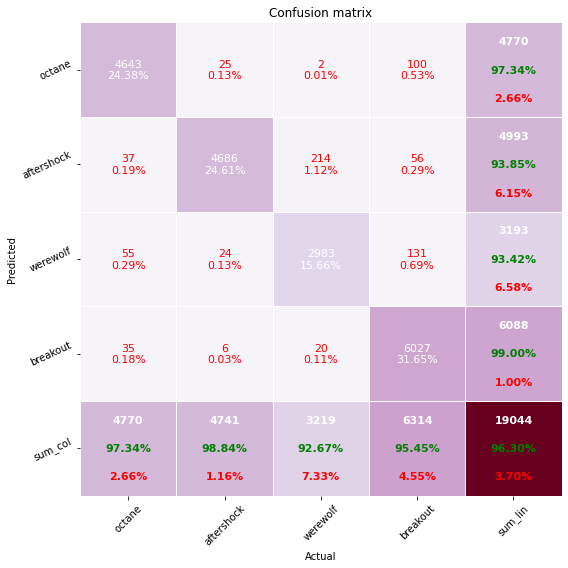

In [128]:
# extraction des vraies catégories du dataset de test
true_categories = tf.concat([label for _, label in ds_test], axis=0)
# print(true_categories.numpy())
print("true categories extracted")

# création des prédictions sur les données de test
prediction = model.predict(ds_test)
prediction = np.argmax(prediction, axis=1)
# print(prediction)
print("predictions computed")

res = tf.math.confusion_matrix(true_categories, prediction)

# get pandas dataframe
df_cm = pd.DataFrame(res, CLASSES, CLASSES)

# pretty_confusion_matrix
pp_matrix(df_cm, cmap="PuRd")

In [ ]:
def make_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [113]:
def make_gradcam(img, heatmap, alpha=0.5):
    # convert img to float32 to support alpha blending
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    jet_heatmap = jet_heatmap / 255

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    return superimposed_img


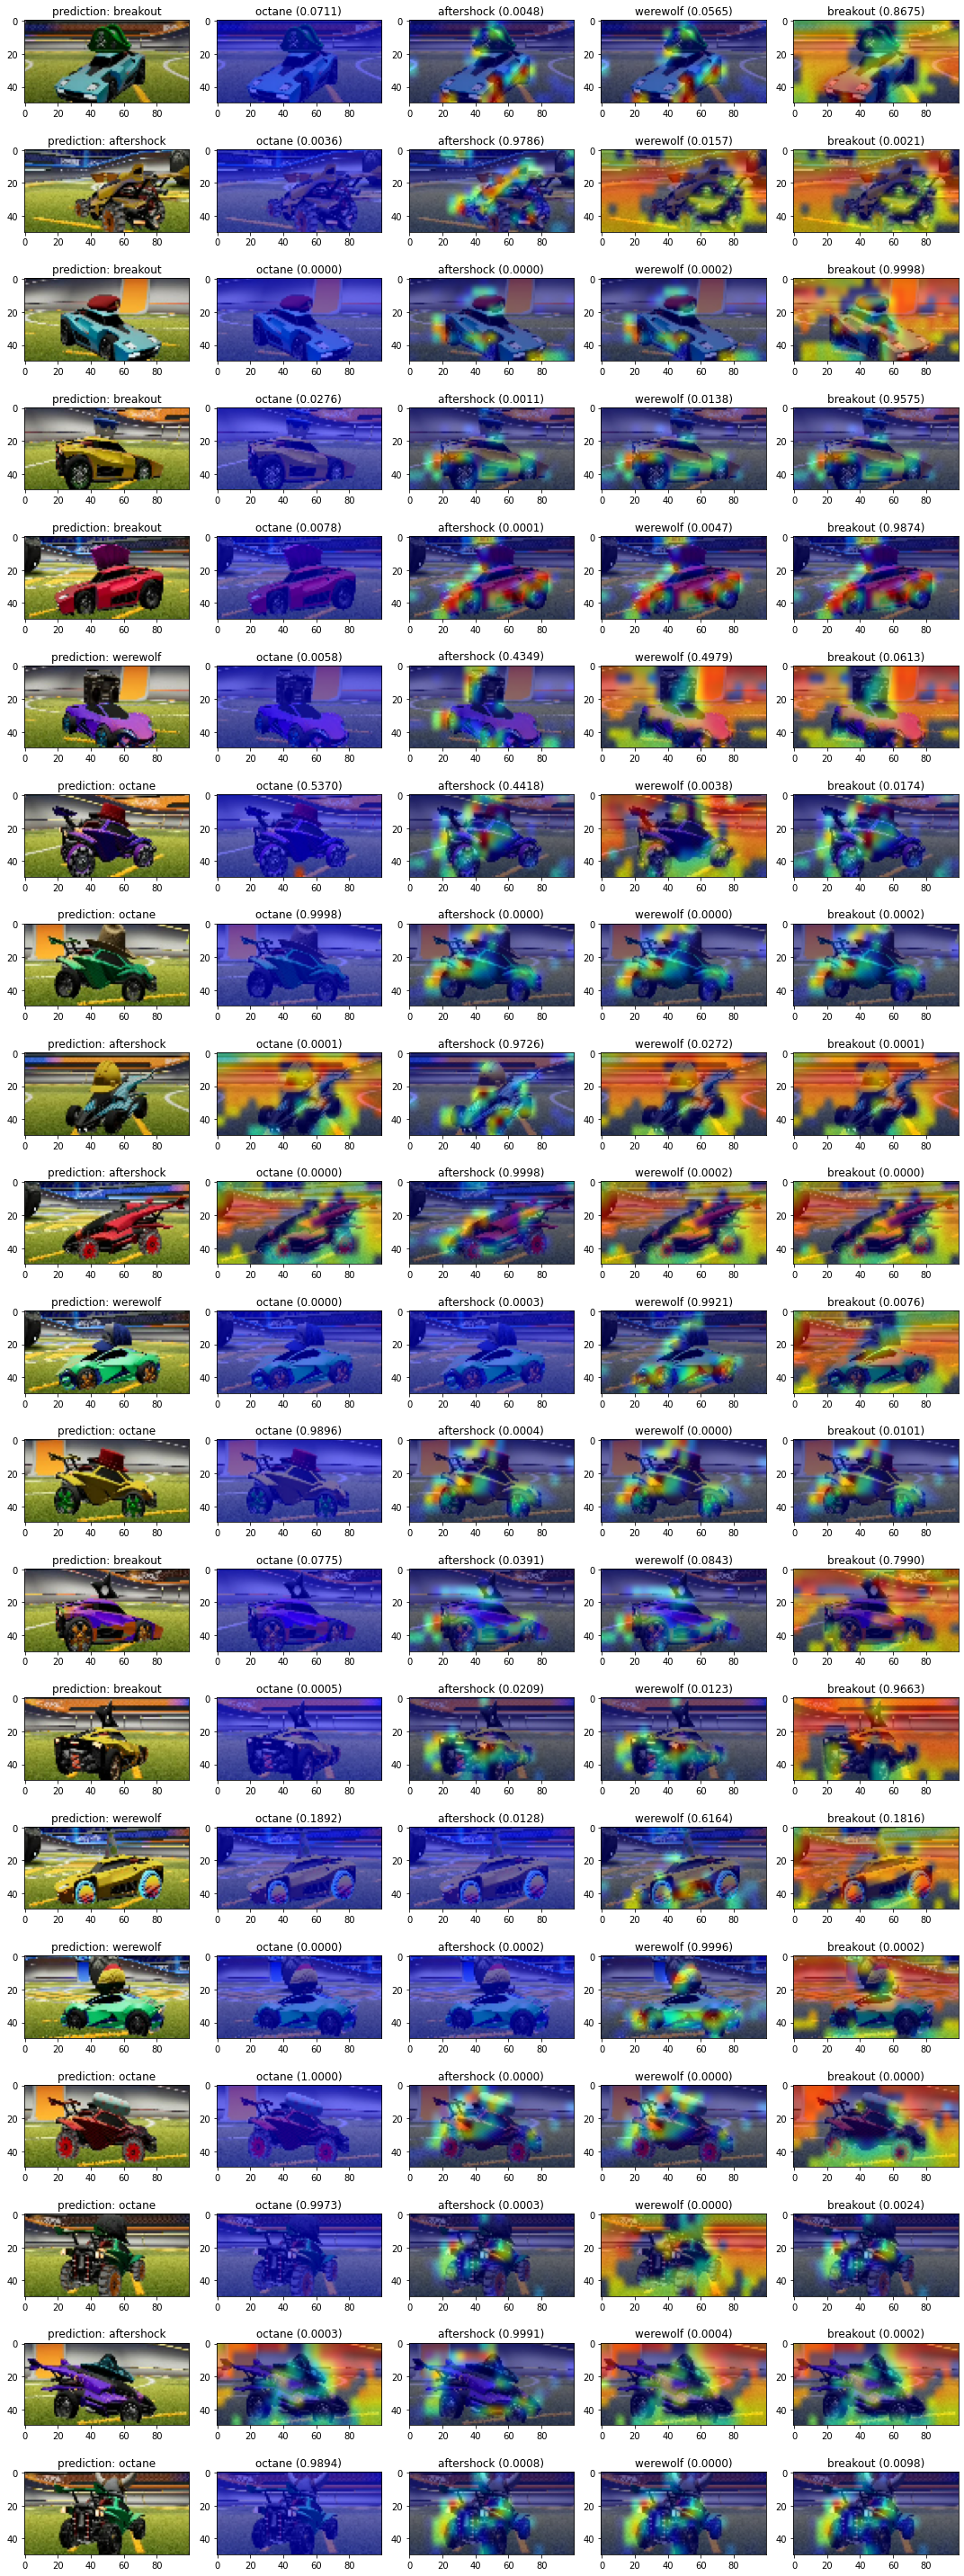

In [127]:
ROWS = 20
last_conv_layer_name = "C2D_last"
plt.figure(figsize=(16, 2*ROWS))

for i, (img, _) in enumerate(ds_test.unbatch().take(ROWS)):

    X = np.zeros((1, RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2]))
    X[0] = np.asarray(img)

    # Print what the top predicted class is
    preds = model.predict(X)
    index = np.argmax(preds)

    plt.subplot(ROWS, 5, 5*i+1)
    plt.imshow(img)
    plt.title(f"prediction: {CLASSES[index]}")

    for j in range(4):
        # generate class activation heatmap
        heatmap = make_heatmap(X, model, last_conv_layer_name, pred_index=j)
        # generate gradmap
        gradcam = make_gradcam(img, heatmap)
        
        plt.subplot(ROWS, 5, 5*i+j+2)
        plt.imshow(gradcam)
        plt.title(f"{CLASSES[j]} ({preds[0][j]:.4f})")

plt.tight_layout()
plt.show()
